# Problema

O problema disposto consistia em tentar predizer as falhas encontradas nos sistemas de comprensão de ar dos caminhões da Scania (APS - Air Pressure System), empresa Suéca. Para tal problema, foram dispostos dados coletados por uso diário dos caminhões da Scania, onde o foco da análise está nos APS que fornece ar comprensado para diversas outras funções dos caminhões, como frenagem e mudança de marchas.

Basicamente, as categorias compostas dentro do dataset são: positivos e negativos. Os **positivos** indicam que os erros encontrados estão no sistema APS. Já os **negativos** indicam que a falha encontrada no caminhão está em componentes que não fazem parte de tal sistema.

# Pré-processamento do dataset

O dado fornecido é composto por um `csv` que possui 60.000 coletas de dados e 171 features ou características desses dados, as quais não são descritas pela Scania por razões de propriedade da empresa.

Tais informações de dados acabou que dificultou o entendimento do problema, visto que não seria possível identificar o que de fato as variáveis representavam dentro da problemática.

In [1]:
import pandas as pd

i=0;
skiprows = []
for i in range(0,20):
    skiprows.append(i)
    i=i+1
    
print('Linhas ignoradas do arquivo (Cabeçalho):{}'.format(skiprows))

df = pd.read_csv('aps_failure_training_set.csv', skiprows=skiprows)

Linhas ignoradas do arquivo (Cabeçalho):[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


## Tratando valores nulos

Como dito na documentação do dataset, os valores não informados na etapa de coleta de dados dentro das 171 variáveis são colocados como 'na' nas colunas. Para isso, foi preciso realizar o tratamento desses valores para que pudessemos aplicar os modelos com um dataframe contendo apenas números.

Substituiu-se então os valores por `NaN` ou `Not a Number`, para podermos utilizar a estratégia de aplicação de mediana para tais valores.

In [3]:
import numpy as np

df.replace({'na': np.nan}, inplace=True, regex=True)
df.replace('neg', 0, inplace=True)
df.replace('pos', 1, inplace=True)
df_with_target = df

In [4]:
from sklearn.preprocessing import Imputer

classes = df.pop('class')

imputer = Imputer(missing_values=np.nan, strategy='median', axis=0)
for column in df:
    df[[column]] = imputer.fit_transform(df[[column]])
    df_with_target[[column]] = imputer.fit_transform(df_with_target[[column]])

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.figure(figsize=(36,20))
heatmap = sns.heatmap(df_with_target.corr(), annot=True, square=True, cmap="YlGnBu", linewidths=.3)
plt.show()

### Escolhedo o melhor K utilizando o método de Elbow

O método de Elbow é um método que análisa o valor do erro quadrático entre os clusters (Within-Clusters Sum of Squares ou WCSS) para a definição do número de clusters mais adequados para o problema. No caso do sklearn esse valor é identificado pela `inertia`.

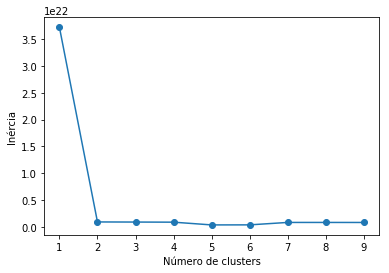

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

inertias = []
centers = []

interval = range(1, 10)
for i in interval:
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=i)
    mbk.fit(df)
    inertias.append(mbk.inertia_)
#     centers.append(mbk.centers_)
                      # batch_size=100,
                      # n_init=10, max_no_improvement=10, verbose=0,
                      # random_state=0)

plt.plot(interval, inertias, '-o')
plt.xlabel('Número de clusters')
plt.ylabel('Inércia')
plt.show()
# plt.plot(interval, centers, '-o')
# plt.xlabel('Número de clusters')
# plt.ylabel('Centroides')
# plt.show()

À partir da aplicação do método de Elbow, é possível ver que a curva tem sua maior diferença entre os clusters de número 1 e de número 2. À partir daí, a linha tende a seguir um modelo mais uniforme, sem grandes variações, o que diz que as diferenças entre as distâncias das amostras do centro do clusters está variando pouco e por isso o método diz que 2 é o melhor número para clusters considerando o dado conjunto de dados analisados, visto que escolhe-se o ultimo cluster o qual a diferença foi significativa.

Sabendo agora do melhor número de Clusters, é possível partir para análises mais profundas sobre o problema.

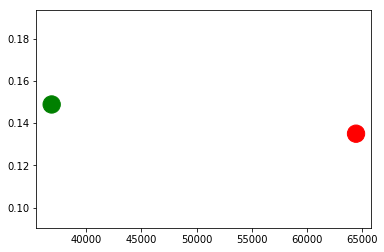

In [25]:
mbk = MiniBatchKMeans(n_clusters=2)
labels = mbk.fit_predict(df)
plt.scatter(mbk.cluster_centers_[:, 0], mbk.cluster_centers_[:, 1], s=300, c='rg', label = 'centros')
plt.show()

## Métricas do Modelo final

Para identificar a qualidade da clusterização sobre os dados idealmente não categorizados, serão utilizadas duas métricas dentro das existentes para a Clusterização: Inertia e Calinski-Harabaz.

The value of the inertia criterion associated with the chosen partition (if compute_labels is set to True). The inertia is defined as the sum of square distances of samples to their nearest neighbor.


* **Inertia**: é definido pela soma dos quadrados das distâncias entre o elemento para seus vizinhos mais próximos;
* **Calinski-Harabaz**: analisa a dispersão média entre os clusters e quanto maior o seu valor melhor.

In [37]:
from sklearn import metrics
def get_metrics(model, data, labels):
    print('Inertia: {}'.format(model.inertia_))
    print('Calinski-Harabaz: {}'.format(metrics.calinski_harabaz_score(data, labels)))

print('Métricas para  k=2  e hiperparâmetros default.')
get_metrics(mbk, df, labels)

Métricas para  k=2  e hiperparâmetros default.
Inertia: 9.47421484759635e+20
Calinski-Harabaz: 2293474.363132915


## Variação dos Hiperparâmetros

O modelo do MiniBatchKMeans possui os seguinte hiperparâmetros relevantes:

* n_clusters: número de clusters que o modelo deve gerar assim como o número de centroides a serem geradas;

* init: Método de inicialização do modelo, default sendo 'k-means++', podendo ser também 'random' ou um array.

  * ‘k-means++’: seleciona os centros dos clusters para o k-mean clustering de maneira rápida para aumentar a convergencia.
  * ‘random’: seleciona randomicamente k observasões dos samples para inicializar o valor das centroides.

  * array: deve ter o tamanho de (n_clusters, n_features) e encontra os centros iniciais.

* max_iter: número máximo de interações sobre o dataset antes de parar independente de qualquer critério de parada;

* batch_size : tamanho dos mini-batchs gerados pelo modelo;

* n_init : número de inicializações randômicas a serem tentadas. Diferentemente do KMeans normal (que utiliza apenas uma única inicialização), e utiliza o melhor n_init mensurados pela inertia_.

In [40]:
inertias = []
calinski = []

for i in range(1, 50):
    mbkm = MiniBatchKMeans(n_clusters = 2, init='k-means++', max_iter=200, n_init=i)
    labels = mbkm.fit_predict(df)
    inertias.append(mbkm.inertia_)
    calinski.append(metrics.calinski_harabaz_score(df, labels))
    
    
print('O mínimo de Inertia é: {} tendo ocorrido com o n_init de {}.\n'.format(min(inertias), inertias.index(min(inertias)) + 1))
print('O máximo de Calinski-Harabaz é: {} tendo ocorrido com o n_init de {}.\n'.format(max(calinski), calinski.index(max(calinski)) + 1))

O mínimo de Inertia é: 9.470605132051891e+20 tendo ocorrido com o n_init de 44.

O máximo de Calinski-Harabaz é: 2293474.363132915 tendo ocorrido com o n_init de 1.

